# Assignment 3 - Epipolar Geometry and 3D Reconstruction 

First name: Vaibhav
<br>
Last name: Motwani
<br>
Matriculation number: 23-139-660

In [1]:
# !pip install ipyvolume
# !pip install ipython_genutils
# !pip install opencv-python
# !pip install matplotlib
# !pip install scipy

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import ipyvolume as ipv

from data import load_homogeneous_coordinates
from utils import eight_points_algorithm, right_epipole, plot_epipolar_line, decompose_essential_matrix, infer_3d, ransac

## Part I: The Eight Point Algorithm

### Load Data

In [3]:
data_dir = './merton_college/'
img1, img2, x1, x2 = load_homogeneous_coordinates(data_dir)

### Estimate the fundamental matrix F

In [4]:
F = eight_points_algorithm(x1, x2) 
assert np.linalg.matrix_rank(F) == 2
print('Estimated fundamental matrix: ')
print(F)

Estimated fundamental matrix: 
[[-8.68735667e-10 -2.69158269e-07  1.10836284e-04]
 [ 8.17971152e-07  3.46490278e-08 -3.07414713e-03]
 [-3.40115724e-04  2.88104353e-03  1.20893546e-01]]


### Plot epipoles and epipolar lines

In [5]:
# compute the epipole
# TODO: implement this function
e = right_epipole(F)

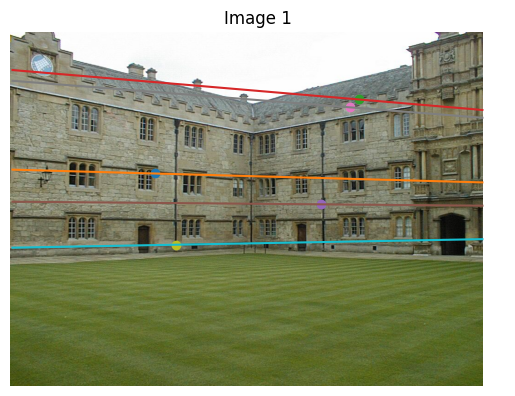

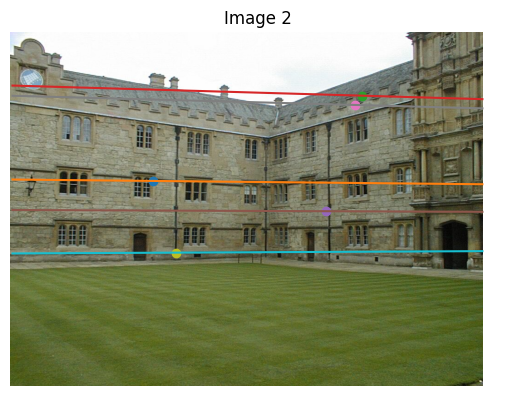

In [6]:
plt.figure()
plt.imshow(img1)
plt.title('Image 1')

# plot of points x1 and epipolar lines constructed using F.T and x2 points 
for i in range(100, 105):
    plt.plot(x1[0, i], x1[1, i], 'o')
    plot_epipolar_line(img1, F.T, x2[:, i], e)

plt.axis('off')
plt.figure()
plt.imshow(img2)
plt.title('Image 2')

# plot of points x2 and epipolar lines constructed using F and x1 points 
for i in range(100, 105):
    plt.plot(x2[0, i], x2[1, i], 'o')
    plot_epipolar_line(img2, F, x1[:, i], e)
    plt.axis('off')

In [7]:
%matplotlib notebook
from ipywidgets import *

fig, ax = plt.subplots()
ax.imshow(img1)

fig2, ax2 = plt.subplots()
ax2.imshow(img2)

def onclick(event):
    ax.plot(event.xdata, event.ydata, 'o')
    plot_epipolar_line(img2, F, np.array([event.xdata, event.ydata, 1]), e)
    ax2.imshow(img2)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Part II: 3D Model Reconstruction

In [8]:
# I added a manual restart of notebook because the above code was causing some issues in loading other images
from IPython.display import display, Javascript

def restart_notebook():
    display(Javascript("Jupyter.notebook.kernel.restart()"))

# Call the function
restart_notebook()

<IPython.core.display.Javascript object>

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import ipyvolume as ipv

from data import load_homogeneous_coordinates
from utils import eight_points_algorithm, right_epipole, plot_epipolar_line, decompose_essential_matrix, infer_3d, ransac

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load matched points
We provide a synthetic pair of images where noisy correspondences are known.

In [10]:
import numpy as np
from PIL import Image

left = np.array(Image.open('MatchedPoints/left.jpg'), dtype=np.float32).mean(2)/255
right = np.array(Image.open('MatchedPoints/right.jpg'), dtype=np.float32).mean(2)/255

Text(0.5, 1.0, 'Right image')

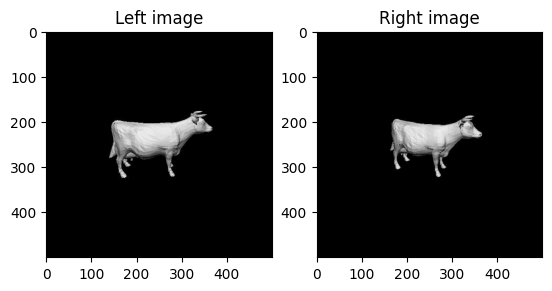

In [11]:
plt.subplot(1,2,1)
plt.imshow(left, cmap='gray')
plt.title('Left image')
plt.subplot(1,2,2)
plt.imshow(right, cmap='gray')
plt.title('Right image')

In [12]:
matriculation_number = 23139660 # TODO
A = np.loadtxt(f'MatchedPoints/Matched_Points_{matriculation_number % 50}.txt')

In [13]:
M, N = A.shape
leftPoints = np.concatenate((A[:,2:4].T, np.ones((1, M))), axis=0)
rightPoints = np.concatenate((A[:,0:2].T, np.ones((1, M))), axis=0)

### Calibration matrix and focal length from the given file

In [14]:
fl = 4
K = np.array([
    [-83.33333, 0.00000, 250.00000],
    [0.00000, -83.33333, 250.00000],
    [0.00000, 0.00000,   1.00000],
])

I = K.copy()

I[0,0] *= fl
I[1,1] *= fl

### Estimate Essential matrix E from F with RANSAC

In [15]:
good_threshold = 0.0001 # TODO
F, inliers = ransac(leftPoints, rightPoints, good_threshold)
print('Num outliers', leftPoints.shape[1] - inliers.sum())
assert np.linalg.matrix_rank(F) == 2
print('Estimated fundamental matrix: ')
print(F)

# TODO: Estimate essential matrix E from F
E = I.T @ F @ I

print('Estimated essential matrix: ')
print(E)

Num outliers 12392
Estimated fundamental matrix: 
[[ 1.08797732e-07 -2.15610286e-05  8.07855345e-03]
 [ 5.99680729e-06  4.53191270e-06  1.17343480e-02]
 [-2.14546708e-03 -9.32403930e-03 -1.39884865e+00]]
Estimated essential matrix: 
[[ 1.20886360e-02 -2.39566965e+00 -9.05165210e-01]
 [ 6.66311868e-01  5.03545815e-01 -4.78884247e+00]
 [ 2.06355265e-01  4.52710591e+00  4.28068719e-03]]


### Compute rotation and translation between views

In [16]:
# TODO: Compute rotation and translation between views. Complete decomposeE
Il = np.linalg.solve(I, leftPoints)
Ir = np.linalg.solve(I, rightPoints)

Pl, Pr = decompose_essential_matrix(E, Il, Ir)

print('Estimated translation: ')
print(Pr[:,3])
print('Estimated rotation: ')
print(Pr[:,:3])

Estimated translation: 
[ 0.86444623 -0.16296858  0.47557751]
Estimated rotation: 
[[ 0.92639365  0.14709155 -0.3466394 ]
 [-0.12933587  0.98883953  0.07395008]
 [ 0.35364817 -0.02367398  0.93507888]]


### Estimate the 3D points

In [18]:
x3D = infer_3d(Il, Ir, Pl, Pr)
fig = ipv.figure()
ipv.quickscatter(x=-x3D[0,:], y=-x3D[1,:], z=-x3D[2,:])

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…